In [1]:
eval_data_fn = "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/experiments/evaluation/eval_data_landing_in_space.csv"

In [30]:
from tqdm import tqdm
import pandas as pd
import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
filters = {
    "config.experiment": "landing_in_space",
    "config.wandb.job_type": "eval"
}
runs = api.runs("tnt/carl-tmlr", filters=filters)

summary_list, config_list, name_list = [], [], []
for run in tqdm(runs):
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv(eval_data_fn, index=False)

100%|██████████| 30/30 [00:00<00:00, 54971.22it/s]


In [8]:
import sys
sys.path.append("../..")
import pandas as pd
from rich import print as printr
from ast import literal_eval
from pathlib import Path
from experiments.carlbench.context_logging import load_wandb_table_to_df
from experiments.policy_transfer.landing_in_space.definitions import gravities

gravities_keys = list(gravities.keys())


base_path = Path("/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/")
wandb_files_folder = "wandb/latest-run/files/"
runs_df = pd.read_csv(eval_data_fn)
rpc_df = []
for index, row in runs_df.iterrows():
    cfg = literal_eval(row["config"])
    traincfg = literal_eval(cfg["traincfg"])
    group_id = traincfg["wandb"]["group"]
    summary = literal_eval(row["summary"])
    wandb_id = cfg["wandb"]["id"]
    exp_folder = "/".join(wandb_id.split("_")[:-1])
    slurm_idx = cfg["slurm_id"].split("_")[-1]
    results_path = base_path / exp_folder / slurm_idx
    rpc_path = Path(results_path) / wandb_files_folder /  summary["return_per_context_table"]["path"]
    rpc = load_wandb_table_to_df(path=rpc_path)
    rpc["visibility"] = [group_id] * len(rpc)
    rpc["planet"] = [gravities_keys[int(i)] for i in rpc["context_id"]]
    rpc["gravity"] = [gravities[gravities_keys[int(i)]] for i in rpc["context_id"]]
    rpc["gravity"] = rpc["gravity"].apply(lambda x: f"{x:.2f}")
    rpc_df.append(rpc)
rpc_df = pd.concat(rpc_df)

/home/benjamin/.conda/envs/py39/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/benjamin/.conda/envs/py39/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


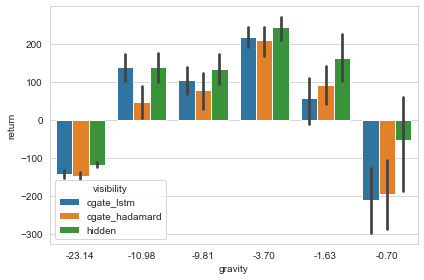

/home/benjamin/.conda/envs/py39/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/home/benjamin/.conda/envs/py39/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


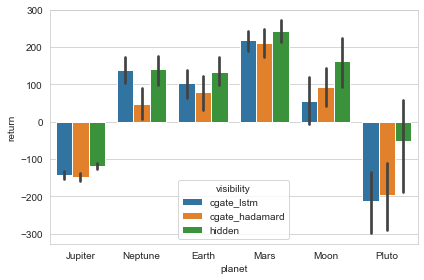

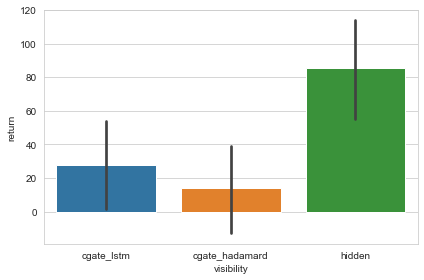

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.barplot(data=rpc_df, x="gravity", y="return", hue="visibility", ax=ax)
fig.set_tight_layout(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.barplot(data=rpc_df, x="planet", y="return", hue="visibility", ax=ax)
fig.set_tight_layout(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.barplot(data=rpc_df, x="visibility", y="return", ax=ax)
fig.set_tight_layout(True)
plt.show()

-23.143693999999996 0.01
-10.983448000000001 60.29140539082129
-9.80665 120.57281078164259
-3.6971070499999996 180.85421617246385
-1.6279039 241.13562156328516
-0.6962721499999999 301.41702695410646


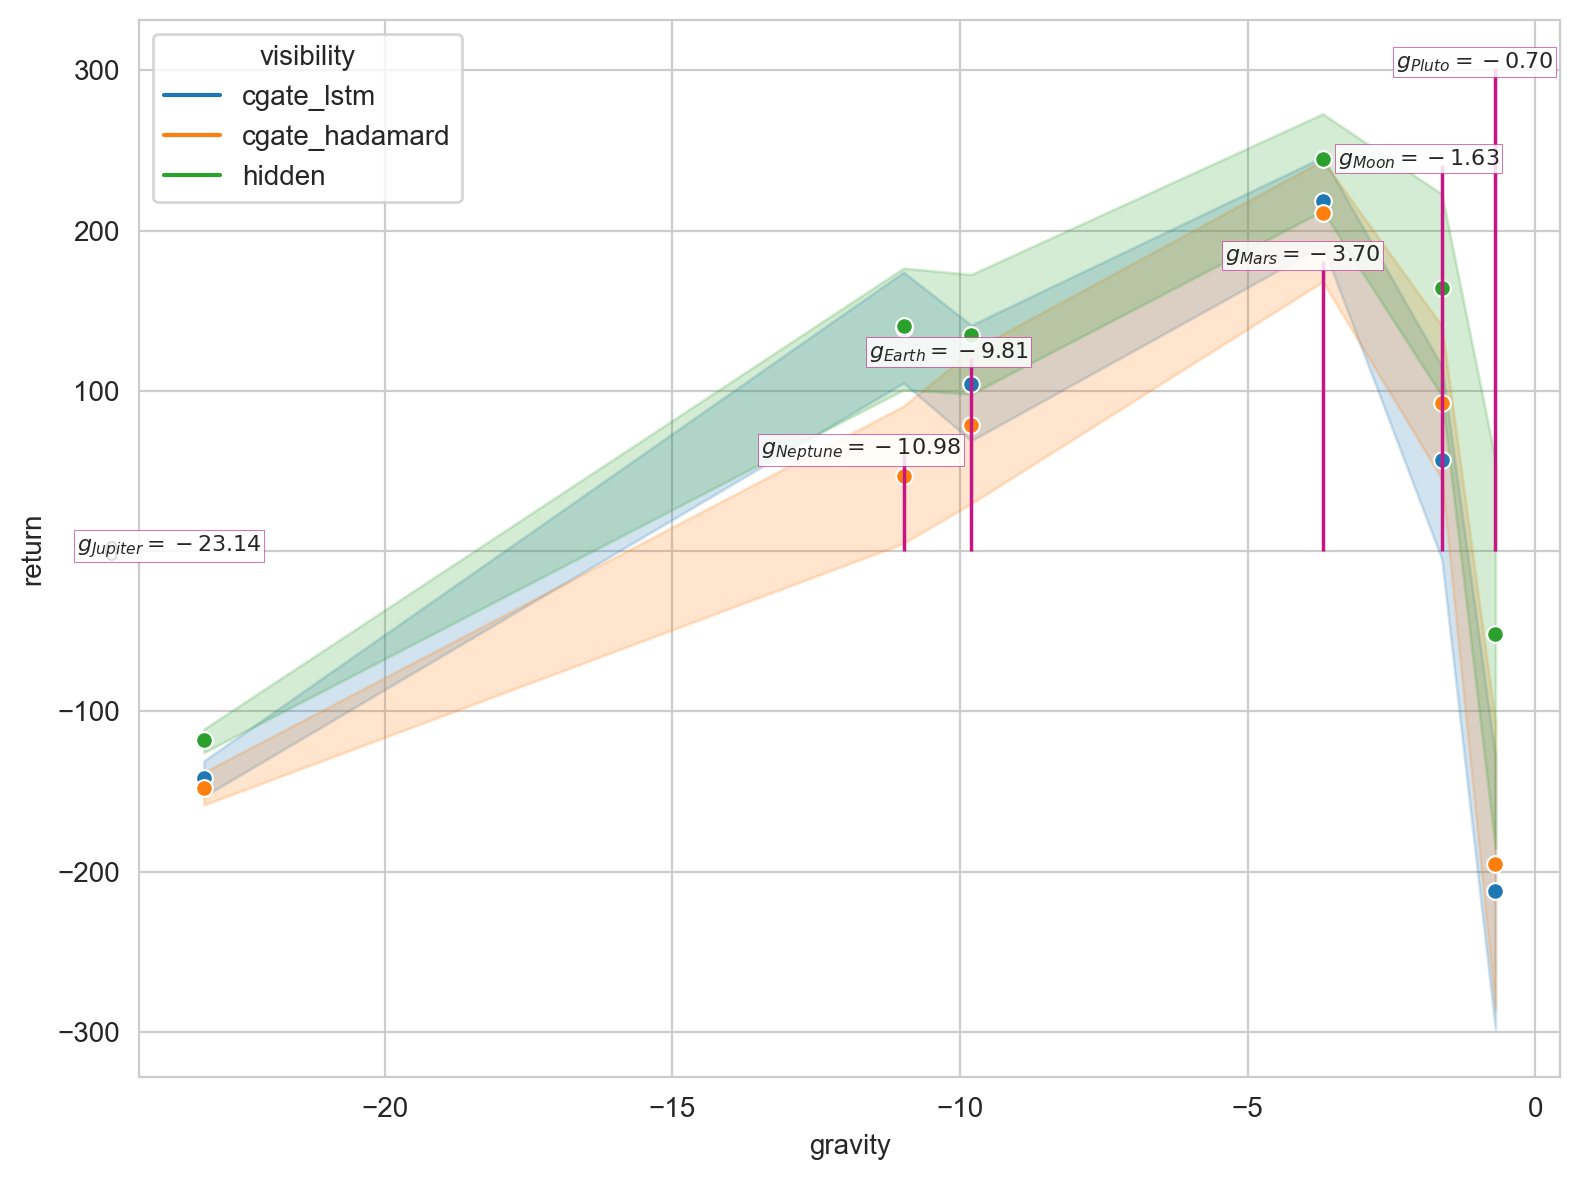

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from experiments.policy_transfer.plot_gravity_distribution import plot_gravities_vlines
sns.set_style("whitegrid")

rpc_df.reset_index(drop=True, inplace=True)
fig = plt.figure(figsize=(8,6), dpi=200)
ax = fig.add_subplot(111)
ax = sns.lineplot(data=rpc_df, x="gravity", y="return", hue="visibility", ax=ax, ls="", marker="o")
ax = plot_gravities_vlines(ax=ax, gravities=gravities, yvalue=ax.get_ylim()[1], mean=-3.7, std=1.45, fontsize=8, shortanno=True)
fig.set_tight_layout(True)
plt.show()

In [4]:
ax.get_xticks()

[0, 1, 2, 3, 4, 5]